## Журнал "Петрология": анализ публикативной активности 1/3

<hr style="border:solid orange 1px">

### Цитирование и активность авторов за все годы

---

Основные задачи анализа оценить:
- количество цитирований публикаций по годам (за весь срок существования журнала);
- выявить публикации, которые не цитируются;
- посмотреть статистику по авторам

В качестве исходных данных используются свободные сведения о цитировании публикаций в системе `Scopus` - scopus.com. Данные представляют собой таблицу с метаданными каждой статьи журнала, а также информацию о ее цитируемости в системе. Исходные данные достаточно простые, верные и не требует специальной предобработки.

Данные предоставлены за весь период учета публикаций в системе `Scopus` (1996-2020 год).
Базы актуальны на `сентябрь 2020 года`. Хотя, конечно, ясно, что данные за 2019 и 2020 года пока неполные.

---

In [1]:
# Загрузка необходимых модулей:
import pandas as pd
import numpy as np

# Подгрузим библиотеки для построения графиков:
import seaborn as sns
import matplotlib.pyplot as plt

# Модуль для игнорирования ошибок и предупреждений:
import warnings
warnings.simplefilter('ignore')

# Изображение картинок в хорошем качестве:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

---

### Загрузка и обработка исходных данных с сайта `Scopus`

In [2]:
# Загрузка датасета и работа с его подготовкой:
# data = pd.read_csv("/kaggle/input/petrology/scopus0820.csv")
data = pd.read_csv("data/scopus_0920.csv")
                   
# Вывод названия столбцов:
data.columns

Index(['Авторы', 'Название', 'Год', 'Том', 'Выпуск ', 'Статья №',
       'Страница начала', 'Страница окончания', 'Количество страниц',
       'Цитирования', 'DOI', 'Ссылка', 'Тип документа', 'Источник'],
      dtype='object')

In [3]:
# Выбор столбцов для последующего анализа:
data = data[['Авторы', 'Название', 'Год', 'Том', 'Выпуск ','Страница начала', 'Страница окончания','Цитирования']]

# Новые названия для всех столбцов:
data.set_axis(['authors','title','year','vol', 'issue','page_start','page_end','cites'],axis = 'columns',inplace = True)

In [4]:
# Заменяем пропуски в численных столбцах (в целом в этой выборке все пропуски можно заменить на 0):
data['page_start'] = data['page_start'].fillna(0)
data['page_end'] = data['page_end'].fillna(0)
data['cites'] = data['cites'].fillna(0)

# Подсчет столбца с суммой страниц:
data['page_sum'] = data['page_end'] + 1 - data['page_start']

In [5]:
# Изменение типа ячеек (меняем числовые столбцы на тип int64):
column_list_for_int = ['cites', 'vol', 'issue', 'page_start', 'page_end', 'page_sum']
for i in column_list_for_int:
    data[i] = data[i].astype('int64')

In [6]:
# Проверим таблицу:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   authors     847 non-null    object
 1   title       847 non-null    object
 2   year        847 non-null    int64 
 3   vol         847 non-null    int64 
 4   issue       847 non-null    int64 
 5   page_start  847 non-null    int64 
 6   page_end    847 non-null    int64 
 7   cites       847 non-null    int64 
 8   page_sum    847 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 59.7+ KB


---

### Количество цитирований публикаций по годам

In [7]:
# Посмотрим на кол-во публикаций и их цитирование за последние 10 лет:
citations_per_year = (data.groupby(['year']).agg({'vol' : 'count', 'cites' : 'sum'})
     .sort_values(by = 'year', ascending = False)
     .reset_index()
)

citations_per_year

,year,vol,cites
0,2020,21,3
1,2019,35,22
2,2018,34,79
3,2017,31,127
4,2016,31,174
5,2015,28,144
6,2014,33,218
7,2013,32,420
8,2012,40,329
9,2011,36,555


In [8]:
citations_per_year.query('year < 2020')[['vol']].describe()

,vol
count,24.000000
mean,34.416667
std,3.922252
min,28.000000
25%,32.750000
50%,34.000000
75%,35.000000
max,49.000000


По идее, количество цитат должно уменьшаться от самых старых выпусков до новых. Отчасти это так происходит, но не всегда.

Также из данных следует то, что всего `847` статей. В среднем количество статей в выпуске составляет `34 шт`, при этом, самый первый выпуск - был самым большим, он включал `49 статей`.

Далее посмотрим на визуализированные данные. Но для начала дополним анализ одной функцией, которая выводит значения на бары

In [9]:
# Функция, которая показывает значения на бар-диаграммах:
def show_values_on_bars(axs, h_v="v", space=0.4, space_y=0, rounded = 0):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + space_y
                value = (p.get_height()).round(rounded)
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() -0.2
                value = (p.get_width()).round(rounded)
                ax.text(_x, _y, value, ha="left", fontsize=8)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

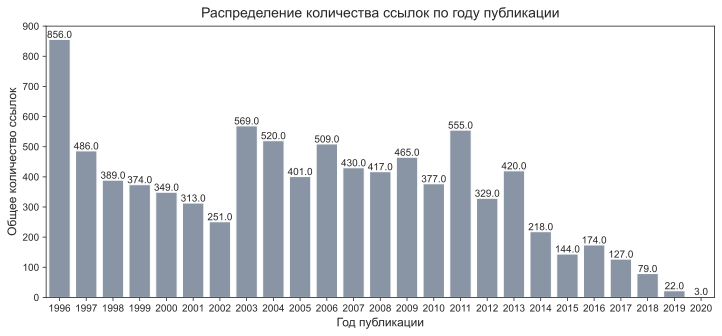

In [10]:
# Построим диаграмму распределения цитируемости по годам:
df = (data
      .groupby(['year'])
      .agg({'vol' : 'count', 'cites' : 'sum'})
      .sort_values(by = 'year', ascending = False)
      .reset_index()
     )


plt.figure(figsize = (12,5))  

# Основной стиль графика:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# Сетка графика:
plt.grid(b=True, which='major', color='black', linewidth=0.05)
plt.grid(b=True, which='minor', color='black', linewidth=0.05)

g = sns.barplot(x="year", 
                y='cites', 
                data=df,
            #    color="#2c3340",
                color="#8595A8",
               )

plt.title("Распределение количества ссылок по году публикации", fontsize=14, y=1.01)

g.set_xlabel('Год публикации', fontsize=12)
g.set_ylabel('Общее количество ссылок', fontsize=12)

show_values_on_bars(g, "v", 0, 5)
g.set(ylim=(0, 900))

plt.savefig("images/cites_per_year.svg", dpi=300, transparent=True, bbox_inches = "tight")

Анализ количества цитирования публикаций по годам показывает, что не все годы одинаковы по цитированию: 
- выделяются публикации таких годов как: `2006`, `2009`, `2011`, `2013`, `2016`, которые на общем фоне имеют большое количество цитирований;
- статьи до `2003` года (кроме 1996 года) имеют плохие показатели цитирования; видимо они уже не актуальны.

---

Далее посмотрим на среднюю цитируемость статьи в год. Для этого, поделим общее значение цитирования на количество лет, за которые ведется статистика.

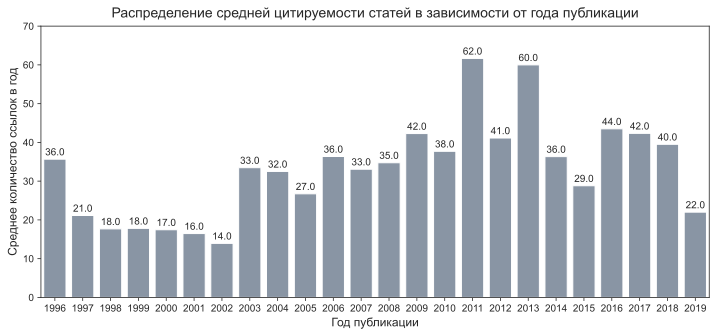

In [11]:
# Построим диаграмму распределения средней цитируемости статей в год:
df = (data
      .query('year < 2020')
      .groupby(['year'])
      .agg({'vol' : 'count', 'cites' : 'sum'})
      .sort_values(by = 'year', ascending = False)
      .reset_index()
     )

df['age'] = df['year'].apply(lambda x: (2020 - x))
df['cites_per_age'] = df['cites'] / df['age']

plt.figure(figsize = (12,5))  

# Основной стиль графика:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# Сетка графика:
plt.grid(b=True, which='major', color='black', linewidth=0.05)
plt.grid(b=True, which='minor', color='black', linewidth=0.05)

g = sns.barplot(x="year", 
                y='cites_per_age', 
                data=df,
                color="#8595A8",
               # palette=np.array(pal[::-1])[rank]
               )

plt.title("Распределение средней цитируемости статей в зависимости от года публикации", fontsize=14, y=1.01)

g.set_xlabel('Год публикации', fontsize=12)
g.set_ylabel('Среднее количество ссылок в год', fontsize=12)

show_values_on_bars(g, "v", 0, 1)
g.set(ylim=(0, 70))

# Вывод графика:
# g.plot()

plt.savefig("images/cites_per_year_mean_data.svg", dpi=300, transparent=True, bbox_inches = "tight")

Полученные выводы в определенной степени коррелируют с выше полученными результатами:
- в среднем в год, статьи имеют около `33-35` цитирований;
- есть годы, которые имеют низкие показатели - `1997-2002`, `2005`, `2015` и пока это `2019` год;
- такие годы как `2009`, `2012`, `2016-2018` и, особенно, `2011` и `2013` показывают хорошие показатели.

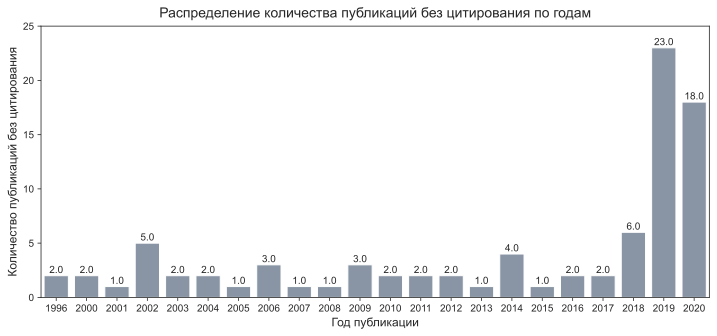

In [12]:
# Построим диаграмму распределения количества публикаций без цитирования по годам:
df = (data
     .query('cites == 0')   
     .groupby(['year']).agg({'vol' : 'count', 'cites' : 'sum'})
     .sort_values(by = 'year', ascending = False)
     .reset_index())

plt.figure(figsize = (12,5))  

# Основной стиль графика:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# Сетка графика:
plt.grid(b=True, which='major', color='black', linewidth=0.05)
plt.grid(b=True, which='minor', color='black', linewidth=0.05)


g = sns.barplot(x="year", 
                y='vol', 
                data=df,
                color="#8595A8",
               )

plt.title("Распределение количества публикаций без цитирования по годам", fontsize=14, y=1.01)

g.set_xlabel('Год публикации', fontsize=12)
g.set_ylabel('Количество публикаций без цитирования', fontsize=12)

show_values_on_bars(g, "v", 0, 0.25)
g.set(ylim=(0, 25))

plt.savefig("images/papers_wo_cites.svg", dpi=300, transparent=True, bbox_inches = "tight")

Также можно отметить, что в каждый год выходят несколько статей, которые не имеют цитат. Как минимум `1 такая статья` есть в каждом году (за исключением `1997-1999 годов`). Понятно, что `2019` и тем более `2020` нельзя рассматривать серьёзно, поскольку `2020` год еще не закончился.

В качестве отрицательного вывода можно отметить, что `2018` год пока имеет большое количество не цитируемых статей, что не очень хорошо.

---

Далее посмотрим на статьи, которые не имеют цитат, а также создадим функцию, которая будет показывать такие статьи. На основе этой функции редколлегия журнала может оценить авторов, которые не имеют цитат или темы, которые были провальны.

In [13]:
# Сводная таблица, иллюстрирующая выводы по не цитируемым статьям:
info = (data.groupby('year')
            .agg({'vol' : 'count', 'cites' : 'sum'})
            .sort_values(by = 'year', ascending = False)
            .reset_index()
       ).merge(
       (data.query('cites == 0')
            .groupby('year')
            .agg({'title' : 'count'})
            .sort_values(by = 'year', ascending = False)
            .reset_index()
       ), left_on = 'year', right_on = 'year', how = 'left')

info.columns = ['year','papers_total','cites_sum','wo_cites']
info.loc[(info['wo_cites'].isna()), 'wo_cites'] = 0
info['wo_cites_proportion'] = (info['wo_cites'] / info['papers_total'] * 100).round(0)

info

,year,papers_total,cites_sum,wo_cites,wo_cites_proportion
0,2020,21,3,18.0,86.0
1,2019,35,22,23.0,66.0
2,2018,34,79,6.0,18.0
3,2017,31,127,2.0,6.0
4,2016,31,174,2.0,6.0
5,2015,28,144,1.0,4.0
6,2014,33,218,4.0,12.0
7,2013,32,420,1.0,3.0
8,2012,40,329,2.0,5.0
9,2011,36,555,2.0,6.0


In [14]:
info.wo_cites.sum()

86.0

Всго таких статей `86` штук из `847` - это много, около 10%. <a class="anchor" id="paper_without_cites"></a>

In [15]:
# Создадим функцию, которая будет показывать статьи без ссылок:
def paper_without_cites(data, year):
    
    ''' Функция, показывающая публикации без цитирования:
            data - имя датафрейма;
            year - годы, для которых берется статистика, значение 'all' - означает все годы
                   можно использовать интервал значений, например '2017, 2018';
    '''
    
    year = pd.Series(year)
    df = data.query('year in @year and cites == 0').sort_values(by = 'cites', ascending = False)
    display(df)

In [16]:
# Посмотрим, как она работает на интервале 2017-2018 годов:
paper_without_cites(data, (2017,2018))

,authors,title,year,vol,issue,page_start,page_end,cites,page_sum
58,"Bataleva Y.V., Palyanov Y.N., Borzdov Y.M., No...",Conditions of Formation of Iron–Carbon Melt In...,2018,26,6,565,574,0,10
59,"Solovova I.P., Averin A.A., Magazina L.O.",Reduced Fluids and Sulfide–Metal Alloy in the ...,2018,26,6,640,649,0,10
63,"Hamdy M.M., Kil Y., Arabia H.A.",Fertile Lithospheric Mantle Beneath the North ...,2018,26,5,546,563,0,18
67,"Gramenitskiy E.N., Shchekina T.I., Alferyeva Y.O.",Processes of Replacement by Melt at Interactio...,2018,26,4,428,446,0,19
70,"Savatenkov V.M., Yarmolyuk V.V., Kozlovsky A.M...",Nd and Pb Isotopic Composition of Granitoids i...,2018,26,4,351,367,0,17
84,"Fedorov P.I., Bogomolov E.S.","Ultrapotassic Volcanism of the Valagin Ridge, ...",2018,26,1,65,81,0,17
98,"Podlesskii K.K., Griboedova I.G., Kurdyukov E.B.",“Ultrahigh-temperature” metamorphism and titan...,2017,25,5,516,525,0,10
118,"Torabi G., Arai S., Morishita T., Tamura A.",Mantle hornblendites of Naein ophiolite (Centr...,2017,25,1,114,137,0,24


---

### Aнализ авторской активности и цитируемости

In [17]:
# Созданим словарь с уникальными авторами и их количеством:
authors = {}

for rec in data['authors']:
    for name in rec.split(','):
        name_without_space = name.strip()
        authors.setdefault(name_without_space, 0)
        authors[name_without_space] += 1

In [18]:
# Созданим словарь с уникальными авторами и их количеством:
authors_wo_cites = {}

for rec in data.query('cites == 0')['authors']:
    for name in rec.split(','):
        name_without_space = name.strip()
        authors_wo_cites.setdefault(name_without_space, 0)
        authors_wo_cites[name_without_space] += 1

Далее создадим на основе этих словарей два датафрейма, один позволит посмотреть на авторов, которые имеют самое большое количество статей, другой на авторов, которые имеют самое большое число нецитируемых статей. Последнее, чтобы их больше не публиковать :)

In [19]:
# Таблица для всех авторов:
authors_stat = pd.DataFrame.from_dict(authors, orient='index').reset_index()
authors_stat.columns = ('name','papers')
authors_stat.sort_values(by = 'papers', ascending = False).head(15)

,name,papers
88,Kotov A.B.,57
2,Yarmolyuk V.V.,54
63,Kovach V.P.,53
608,Kovalenko V.I.,39
451,Sal'nikova E.B.,38
409,Yakovleva S.Z.,29
193,Bogatikov O.A.,25
25,Silantyev S.A.,23
60,Kozakov I.K.,21
300,Sharkov E.V.,20


In [20]:
authors_stat.name.count()

1263

Всего `1263` авторов участвовало в написании 847 статей.

In [21]:
# Таблица для всех авторов, статьи которых не цитируются:
authors_wo_cites_stat = pd.DataFrame.from_dict(authors_wo_cites, orient='index').reset_index()
authors_wo_cites_stat.columns = ('name','papers')
authors_wo_cites_stat.sort_values(by = 'papers', ascending = False).head(15)

,name,papers
2,Yarmolyuk V.V.,4
46,Kozakov I.K.,3
48,Salnikova E.B.,3
19,Dubinina E.O.,3
120,Salova T.P.,3
118,Simakin A.G.,3
217,[автор не найден],2
81,Fedorovsky V.S.,2
80,Lavrenchuk A.V.,2
79,Sklyarov E.V.,2


In [22]:
authors_wo_cites_stat.name.count()

263

Как следует из данных, `263` автора имеют статьи без цитат (`86 штук`), при этом, у этих авторов также есть большое количество статей с цитатами. Так что, автор не так показателен. Видимо все дело в теме публикации.

---

Далее введем такую метрику, как индекс цитируемости публикации, или индекс жизни. Расчет индекса цитируемости статьи,  будет равен `количество цитат / на количество лет`, которые статья существует.

<a class="anchor" id="authors_stat"></a>

In [23]:
# Создадим новый столбец - возраст статьи (разница с 2020 годом):
data['paper_age'] = 2020 - data['year']
data.loc[(data['paper_age'].isna()), 'paper_age'] = 0

# Подсчитаем индекс цитируемости статей:
data['paper_index'] = data['cites'] / data['paper_age']
data = data.replace([np.inf, -np.inf], np.nan)
data.loc[(data['paper_index'].isna()), 'paper_index'] = 0

# Посмотрим, что вышло:
data.query('year == 2018').head()

,authors,title,year,vol,issue,page_start,page_end,cites,page_sum,paper_age,paper_index
56,"Matrosova E.A., Bobrov A.V., Bindi L., Irifune T.",Phase Relations in the Model System SiO2–MgO–C...,2018,26,6,588,598,2,11,2,1.0
57,"Safonov O.G., van Reenen D.D., Yapaskurt V.O.,...",Thermal and Fluid Effects of Granitoid Intrusi...,2018,26,6,617,639,1,23,2,0.5
58,"Bataleva Y.V., Palyanov Y.N., Borzdov Y.M., No...",Conditions of Formation of Iron–Carbon Melt In...,2018,26,6,565,574,0,10,2,0.0
59,"Solovova I.P., Averin A.A., Magazina L.O.",Reduced Fluids and Sulfide–Metal Alloy in the ...,2018,26,6,640,649,0,10,2,0.0
60,"Kruk A.N., Sokol A.G., Palyanov Y.N.",Phase Relations in the Harzburgite–Hydrous Car...,2018,26,6,575,587,1,13,2,0.5


In [24]:
# Создадим функцию, которая будет выводить информацию по авторам:
def authors_stat(data, name, year = 'all'):
        
    ''' Функция, показывающая информацию по авторам:
            data - имя датафрейма;
            year - годы, для которых берется статистика, значение 'all' - означает все годы
                   можно использовать интервал значений, например '2017, 2018';
            name - фамилия автора (на англ)
    '''
 
    if year == 'all':
        df = data[data['authors'].str.contains(name)].reset_index(drop = True)
    else:
        year = pd.Series(year)
        df = data.query('year in @year')[data['authors'].str.contains(name)].reset_index(drop = True)
    display(df)    

In [25]:
# Проверим функцию:
authors_stat(data, 'Samsonov')

,authors,title,year,vol,issue,page_start,page_end,cites,page_sum,paper_age,paper_index
0,"Erofeeva K.G., Samsonov A.V., Stepanova A.V., ...",Olivine and Clinopyroxene Phenocrysts as a Pro...,2020,28,4,338,356,0,19,0,0.000000
1,"Stepanova A.V., Samsonov A.V., Larionova Y.O.,...",1860-Ma I-Shaped Mafic Sills in the Murmansk C...,2020,28,2,93,117,1,25,0,0.000000
2,"Erofeeva K.G., Stepanova A.V., Samsonov A.V., ...",2.4 Ga Mafic Dikes and Sills of Northern Fenno...,2019,27,1,17,42,3,26,1,3.000000
3,"Savko K.A., Samsonov A.V., Sal’nikova E.B., Ko...",HT/LP metamorphic zoning in the eastern Vorone...,2015,23,6,559,575,8,17,5,1.600000
4,"Yakubovich O.V., Shukolyukov Y.A., Kotov A.B.,...","U-Th-He dating of native gold: First results, ...",2014,22,5,429,437,2,9,6,0.333333
5,"Savko K.A., Samsonov A.V., Larionov A.N., Lari...",Paleoproterozoic A- and S-granites in the east...,2014,22,3,205,233,15,29,6,2.500000
6,"Larionova Yu.O., Samsonov A.V., Shatagin K.N.",Sources of Archean sanukitoids (High-Mg subalk...,2007,15,6,530,550,27,21,13,2.076923
7,"Samsonov A.V., Bibikova E.V., Larionova Yu.O.,...",Magnesian granitoids (sanukitoids) of the Kost...,2004,12,5,437,468,17,32,16,1.062500
8,"Bibikova E.V., Samsonov A.V., Shchipansky A.A....",The Hisovaara structure in the northern Kareli...,2003,11,3,261,290,21,30,17,1.235294


С помощью этой функции можно посмотреть публикации отдельных авторов, оценить цитируемость их статей и количество ссылок.

<a class="anchor" id="authors_stat_bar"></a>

In [26]:
# Проверим функцию:
def authors_stat_bar(data, name, year, types, figure = False):
    if year == 'all':
        df = data[data['authors'].str.contains(name)].reset_index(drop = True)
    else:
        year = pd.Series(year)
        df = data.query('year in @year')[data['authors'].str.contains(name)].reset_index(drop = True)
    
    if types == 'cites':
        df = (df.groupby(['year']).agg({'cites' : 'sum'})
             .sort_values(by = 'year', ascending = False)
             .reset_index()
        )
        y = 'cites'
        y_title = 'Количество цитат'
        title = (name + ": распределение количества цитирования по годам")
        file_name = ('images/authors/' + name + '_cites.svg')
        
    else:
        df = (df.groupby(['year']).agg({'paper_index' : 'mean'})
             .sort_values(by = 'year', ascending = False)
             .reset_index()
        )
        y = 'paper_index'
        y_title = 'Значение индекса'
        title = (name + ": авторский индекс публикаций по годам")
        file_name = ('images/authors/' + name + '_index.svg')
        
    plt.figure(figsize = (7,3))  

    # Основной стиль графика:
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

    # Сетка графика:
    plt.grid(b=True, which='major', color='black', linewidth=0.05)
    plt.grid(b=True, which='minor', color='black', linewidth=0.05)

    g = sns.barplot(x="year", 
                    y=y,
                    data=df,
                    color="#8595A8",
                   )
      
    plt.title(title, fontsize=14, y=1.01)

    g.set_xlabel('Год публикации', fontsize=12)
    g.set_ylabel(y_title, fontsize=12)

    show_values_on_bars(g, "v", 0, 0, 2)

    if figure == True:
        plt.savefig(file_name, dpi=300, transparent=True, bbox_inches = "tight")
    else:
        None  

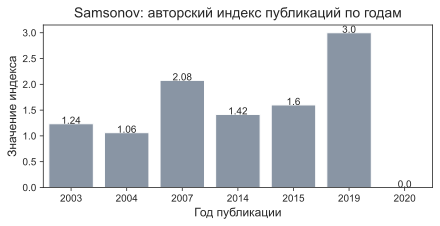

In [27]:
# Проверим функцию:
authors_stat_bar(data, 'Samsonov', 'all', 'paper_index', True)

Создадим функцию, которая будет считать средний индекс публикации для автора. 

<a class="anchor" id="author_index"></a>

In [28]:
# Создадим функцию, которая будет считать средний индекс публикации для автора:
def author_index(data, name, year = 'all'):
            
    ''' Функция, отображающая средний индекс публикации для автора:
            data - имя датафрейма;
            year - годы, для которых берется статистика, значение 'all' - означает все годы
                   можно использовать интервал значений, например '2017, 2018';
            name - фамилия автора (на англ)
    '''
 
    if year == 'all':
        index = data[data['authors'].str.contains(name)]['paper_index'].mean()
    else:
        year = pd.Series(year)
        index = data.query('year in @year')[data['authors'].str.contains(name)]['paper_index'].mean()

    print(name, '{:.3}'.format(index))

In [29]:
# Проверим функцию:
author_index(data, 'Samsonov', 'all')

Samsonov 1.31


Создадим функцию - сводную таблицу, которая будет отображать количество публикаций каждого автора и его рейтинги.

<a class="anchor" id="authors_rating"></a>

In [30]:
# Создадим функцию - сводную таблицу, которая будет отображать количество публикаций каждого автора и его рейтинги:
def authors_rating(data, sorting, number, year = 'all'):
            
    ''' Функция, отображающая количество публикаций каждого автора и его рейтинги:
            data - имя датафрейма;
            year - годы, для которых берется статистика, значение 'all' - означает все годы
                   можно использовать интервал значений, например '2017, 2018';
            sorting - условия сортировки:
                    - 'cites' - количество ссылок в целом;
                    - 'cites_per_paper' - среднее количество ссылок на 1 публикацию автора;
                    - 'author_index' - индекс автора
            number - количество записей
    '''
    
    if year == 'all':
        df = data
    else:
        year = pd.Series(year)
        df = data.query('year in @year').reset_index(drop = True)
        
    stats = {}
    for rec in df['authors']:
        for name in rec.split(','):
            name_without_space = name.strip()
            stats.setdefault(name_without_space, 0)
            stats[name_without_space] += 1
        
    authors_columns = ['author', 'papers', 'cites', 'cites_per_paper', 'author_index']
    authors_index = []

    for i in stats.keys():
        df_author =  df[df['authors'].str.contains(i)]
        papers = df_author['title'].count() 
        cites  = df_author['cites'].sum() 
        index  = df_author['paper_index'].mean()
        cite_index = df_author['cites'].mean()
        authors_index.append([i, papers, cites, cite_index, index]) 

    authors = (pd.DataFrame(authors_index, columns = authors_columns)
               .query('author != "[автор не найден]"') 
               .sort_values(by = sorting, ascending = False)
               .head(number)
              )
    display(authors.style.format({
            'cites_per_paper': "{:.2f}", 
            'author_index': '{:.2f}'
        })
               )

In [31]:
# Проверим функцию:
authors_rating(data, 'cites', 15)

,author,papers,cites,cites_per_paper,author_index
63,Kovach V.P.,53,1267,23.91,1.94
2,Yarmolyuk V.V.,54,1182,21.89,1.80
88,Kotov A.B.,57,1115,19.56,1.69
608,Kovalenko V.I.,39,906,23.23,1.54
451,Sal'nikova E.B.,38,786,20.68,1.43
409,Yakovleva S.Z.,29,552,19.03,1.62
60,Kozakov I.K.,21,466,22.19,1.80
473,Bibikova E.V.,14,462,33.00,2.39
692,Sobolev A.V.,4,419,104.75,5.18
570,Berezhnaya N.G.,10,285,28.50,1.74


<hr style="border:solid orange 1px">

### Промежуточные выводы

---

Анализ публикаций журнала за весь период учета в базе `Scopus` показал, что:
- в базе данных `847` статей, в написании которых участвовало `1263` авторов;
- в среднем количество статей в выпуске составляет `34 шт`, при этом, самый первый выпуск - был самым большим, он включал `49 статей`;
- анализ количества цитирования публикаций по годам показывает, что не все годы одинаковы по цитированию: 
    - выделяются публикации таких годов как: `2006`, `2009`, `2011`, `2013`, `2016`, которые на общем фоне имеют большое количество цитирований;
    - статьи до `2003` года (кроме 1996 года) имеют плохие показатели цитирования; видимо они уже не актуальны.
- в среднем в год, статьи одного выпуска (года) имеют около `33-35` цитирований, при этом:
    - есть годы, которые имеют низкие показатели - 1997-2002, 2005, 2015 и пока это 2019 год;
    - такие годы как 2009, 2012, 2016-2018 и, особенно, 2011 и 2013 показывают хорошие показатели;
- в каждый год выходят несколько статей, которые не имеют цитат. Как минимум 1 такая статья есть в каждом году (за исключением 1997-1999 годов), всего таких статей `86`, что составляет порядка `10%` от всего количества статей - это много (однако в этой статистике участвуют данные по 2019 и 2020 годам, что нельзя рассматривать серьёзно, поскольку 2020 год еще не закончился);
- к этим `86` статьям причастны `263` автора; при этом, у этих авторов также есть большое количество статей с цитатами. Так что, автор не так показателен. Видимо все дело в теме публикации.

---

Для удобства анализа данных были созданы несколько функций, которые позволяют:
- [**paper_without_cites(data, year)**](#paper_without_cites) - функция, показывающая публикации без цитирования.
- [**authors_stat(data, year)**](#authors_stat) и - [**authors_stat_bar(data, year)**](#authors_stat_bar) с помощью этих функций можно посмотреть публикации отдельных авторов, оценить цитируемость их статей и количество ссылок.
- [**paper_without_cites(data, year)**](#authors_rating) - функция, отображающая количество публикаций каждого автора и его рейтинги.